In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

from dataset import FeatureDataset
from models import *
from utility import train, validate, test_validate
from sklearn.model_selection import KFold


In [2]:
# Parametri
input_dim = 2048  # Dimensione dell'input
num_classes = 251  # Numero di classi
batch_size = 2048  
epochs = 100
learning_rate = 0.01

In [5]:
training_set = FeatureDataset('../dataset/features_extended_20.npz',
                              type='train',
                              target_transform=lambda y: F.one_hot(y, num_classes=num_classes))

validation_set = FeatureDataset('../dataset/features_extended_20.npz',
                                type='val',
                                target_transform=lambda y: F.one_hot(y, num_classes=num_classes))

test_set = FeatureDataset('../dataset/test_features_resnet50.npz',
                          type='test',
                          target_transform=lambda y: F.one_hot(y, num_classes=num_classes))

test_set_degraded = FeatureDataset('../dataset/test_degraded_features_resnet50.npz',
                                type='test',
                                target_transform=lambda y: F.one_hot(y, num_classes=num_classes))

In [6]:
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
test_degraded_loader = DataLoader(test_set_degraded, batch_size=batch_size, shuffle=False)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


# Classification using NN 

In [7]:
# Inizializza il modello, la loss e l'optimizer
model = ClassifierNetwork(training_set.get_dim(), training_set.get_n_classes()).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Decrementa lr ogni 5 epoche

ClassifierNetwork(
  (layers): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=251, bias=True)
  )
)


In [8]:
best_val_loss = float('inf')
early_stop_counter = 0
curr_epoch = 0
patience = 10  # Numero massimo di epoche senza miglioramenti per fermare l'addetramento

# Training e validazione
# Addestramento con monitoraggio della loss e dell'accuratezza
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [9]:
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, y_pred, y_true = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    curr_epoch += 1
    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        best_model_state = model.state_dict()
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("\nEarly stopping triggered. Stopping training.")
        break

    # Scheduler step
    scheduler.step()

Epoch 1/100:
  Train Loss: 3.9996, Train Accuracy: 17.09%
  Val Loss: 4.9218, Val Accuracy: 12.73%
Epoch 2/100:
  Train Loss: 2.9471, Train Accuracy: 29.90%
  Val Loss: 4.2783, Val Accuracy: 20.72%
Epoch 3/100:
  Train Loss: 2.5980, Train Accuracy: 35.11%
  Val Loss: 4.1089, Val Accuracy: 26.20%
Epoch 4/100:
  Train Loss: 2.3437, Train Accuracy: 39.77%
  Val Loss: 4.2472, Val Accuracy: 30.38%
Epoch 5/100:
  Train Loss: 2.1222, Train Accuracy: 44.44%
  Val Loss: 4.3767, Val Accuracy: 31.20%
Epoch 6/100:
  Train Loss: 1.8632, Train Accuracy: 50.85%
  Val Loss: 4.2241, Val Accuracy: 32.91%
Epoch 7/100:
  Train Loss: 1.7659, Train Accuracy: 53.16%
  Val Loss: 4.2055, Val Accuracy: 33.59%
Epoch 8/100:
  Train Loss: 1.7272, Train Accuracy: 54.32%
  Val Loss: 4.1752, Val Accuracy: 34.36%
Epoch 9/100:
  Train Loss: 1.6781, Train Accuracy: 55.67%
  Val Loss: 4.1921, Val Accuracy: 34.70%
Epoch 10/100:
  Train Loss: 1.6555, Train Accuracy: 56.19%
  Val Loss: 4.1792, Val Accuracy: 35.22%
Epoch 11/

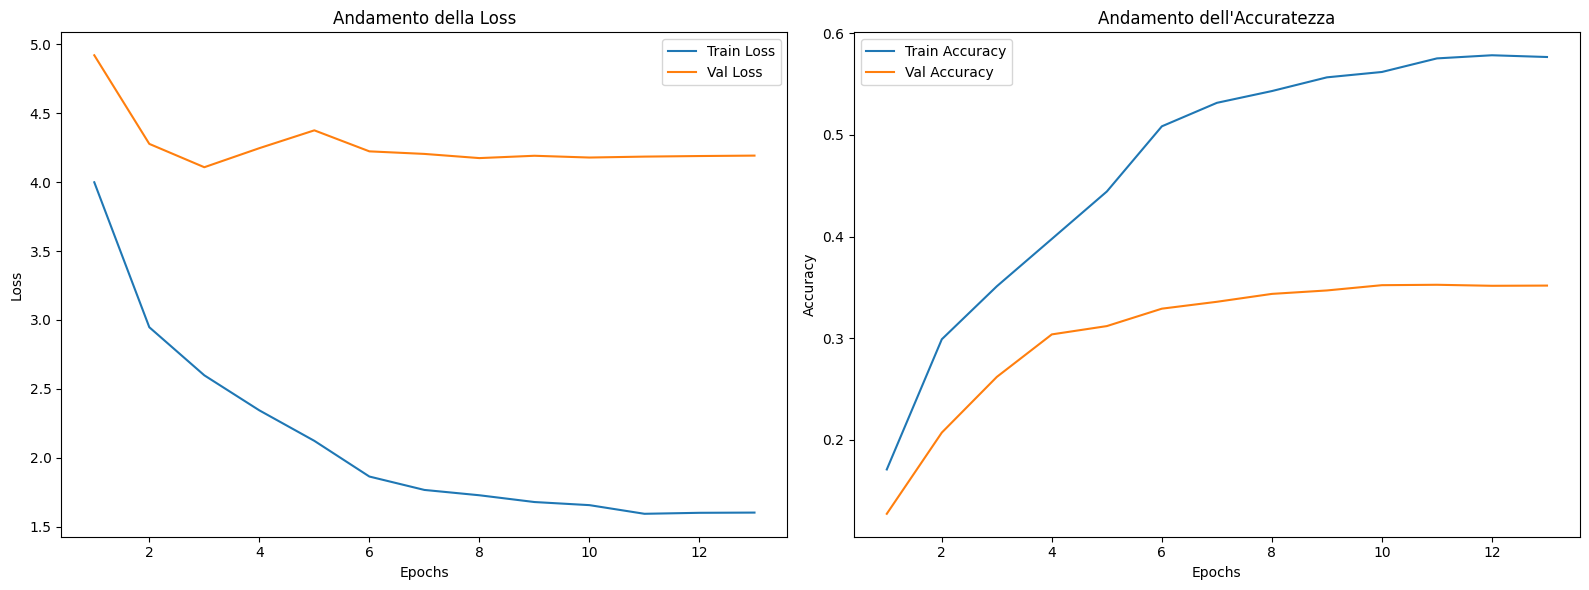

In [10]:
# Grafico della loss e dell'accuratezza
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, curr_epoch + 1), train_losses, label='Train Loss')
plt.plot(range(1, curr_epoch + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Andamento della Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, curr_epoch + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, curr_epoch + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Andamento dell\'Accuratezza')
plt.legend()

plt.tight_layout()
plt.show()

Test set pulito

In [11]:
# Fase di test pulito
test_loss, test_accuracy_top1, test_accuracy_top5, y_test_pred, y_test_true = test_validate(model, test_loader, criterion, device)

print("\nRisultati sul Test Set pulito:")
print(f"  Test Loss: {test_loss:.4f}, Test Accuracy top1: {test_accuracy_top1 * 100:.2f}%, Test Accuracy top5: {test_accuracy_top5 * 100:.2f}%")


Risultati sul Test Set pulito:
  Test Loss: 4.5374, Test Accuracy top1: 20.66%, Test Accuracy top5: 41.26%


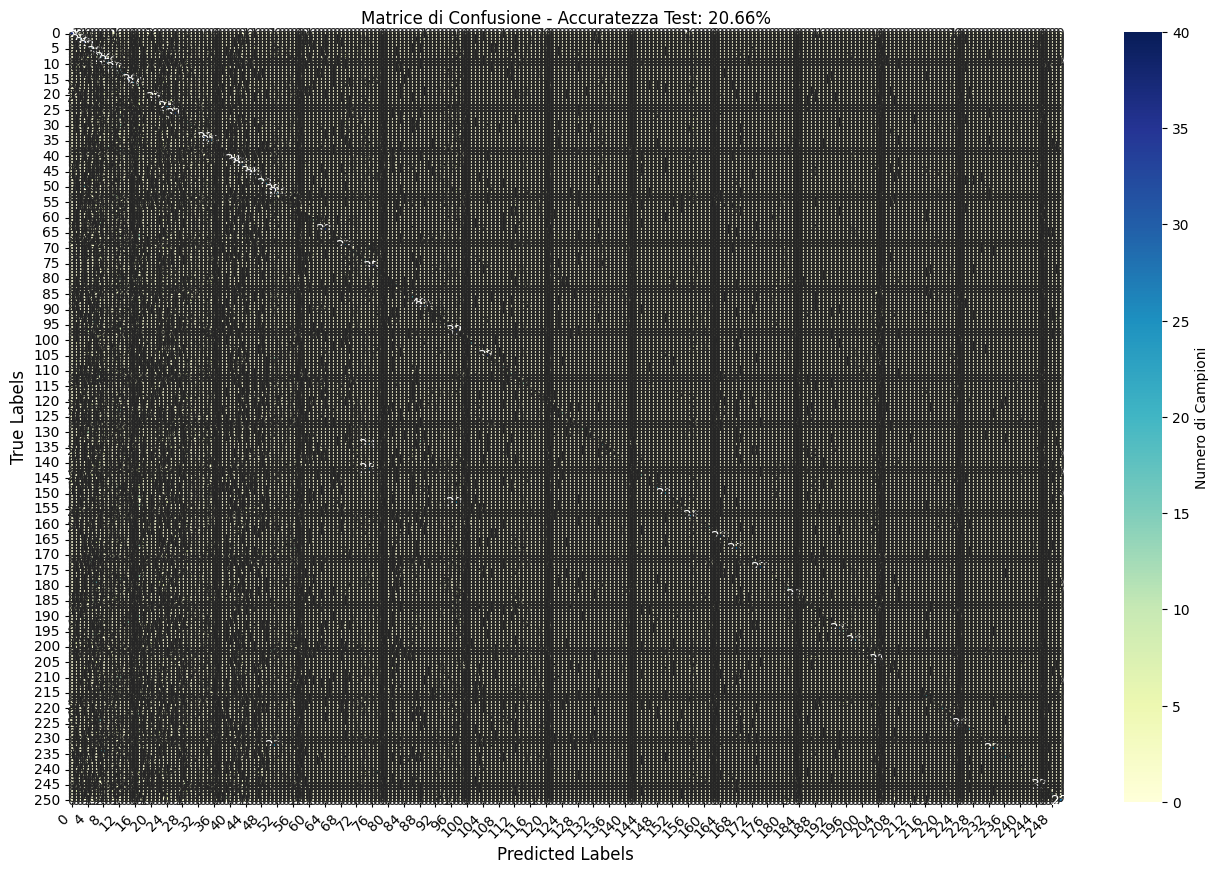

In [12]:
# Matrice di confusione per il test set
y_test_pred_classes = y_test_pred
y_test_true_classes = np.argmax(y_test_true, axis=1)
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Visualizzazione matrice di confusione
plt.figure(figsize=(16, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            cbar_kws={'label': 'Numero di Campioni'}, annot_kws={"size": 10})
plt.title(f"Matrice di Confusione - Accuratezza Test: {test_accuracy_top1 * 100:.2f}%")
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [13]:
# Accuratezza per classe per il test set
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nAccuratezza per Classe sul Test Set:")
for i, acc in enumerate(class_accuracies):
    print(f"  Classe {i}: Accuratezza = {acc * 100:.2f}%")


Accuratezza per Classe sul Test Set:
  Classe 0: Accuratezza = 67.27%
  Classe 1: Accuratezza = 57.38%
  Classe 2: Accuratezza = 43.40%
  Classe 3: Accuratezza = 64.71%
  Classe 4: Accuratezza = 51.22%
  Classe 5: Accuratezza = 28.85%
  Classe 6: Accuratezza = 52.63%
  Classe 7: Accuratezza = 20.37%
  Classe 8: Accuratezza = 48.98%
  Classe 9: Accuratezza = 52.17%
  Classe 10: Accuratezza = 25.00%
  Classe 11: Accuratezza = 42.55%
  Classe 12: Accuratezza = 40.00%
  Classe 13: Accuratezza = 31.15%
  Classe 14: Accuratezza = 15.22%
  Classe 15: Accuratezza = 52.63%
  Classe 16: Accuratezza = 48.98%
  Classe 17: Accuratezza = 21.05%
  Classe 18: Accuratezza = 29.03%
  Classe 19: Accuratezza = 18.37%
  Classe 20: Accuratezza = 9.52%
  Classe 21: Accuratezza = 67.92%
  Classe 22: Accuratezza = 33.33%
  Classe 23: Accuratezza = 30.36%
  Classe 24: Accuratezza = 46.30%
  Classe 25: Accuratezza = 12.07%
  Classe 26: Accuratezza = 54.39%
  Classe 27: Accuratezza = 22.22%
  Classe 28: Accurate

Test set degradato

In [14]:
# Fase di test su immagini degradate
test_loss, test_accuracy_top1, test_accuracy_top5, y_test_pred, y_test_true = test_validate(model, test_degraded_loader, criterion, device)

print("\nRisultati sul Test Set degradato:")
print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy_top1 * 100:.2f}%, Test Accuracy top5: {test_accuracy_top5 * 100:.2f}%")


Risultati sul Test Set degradato:
  Test Loss: 5.4160, Test Accuracy: 14.48%, Test Accuracy top5: 30.77%


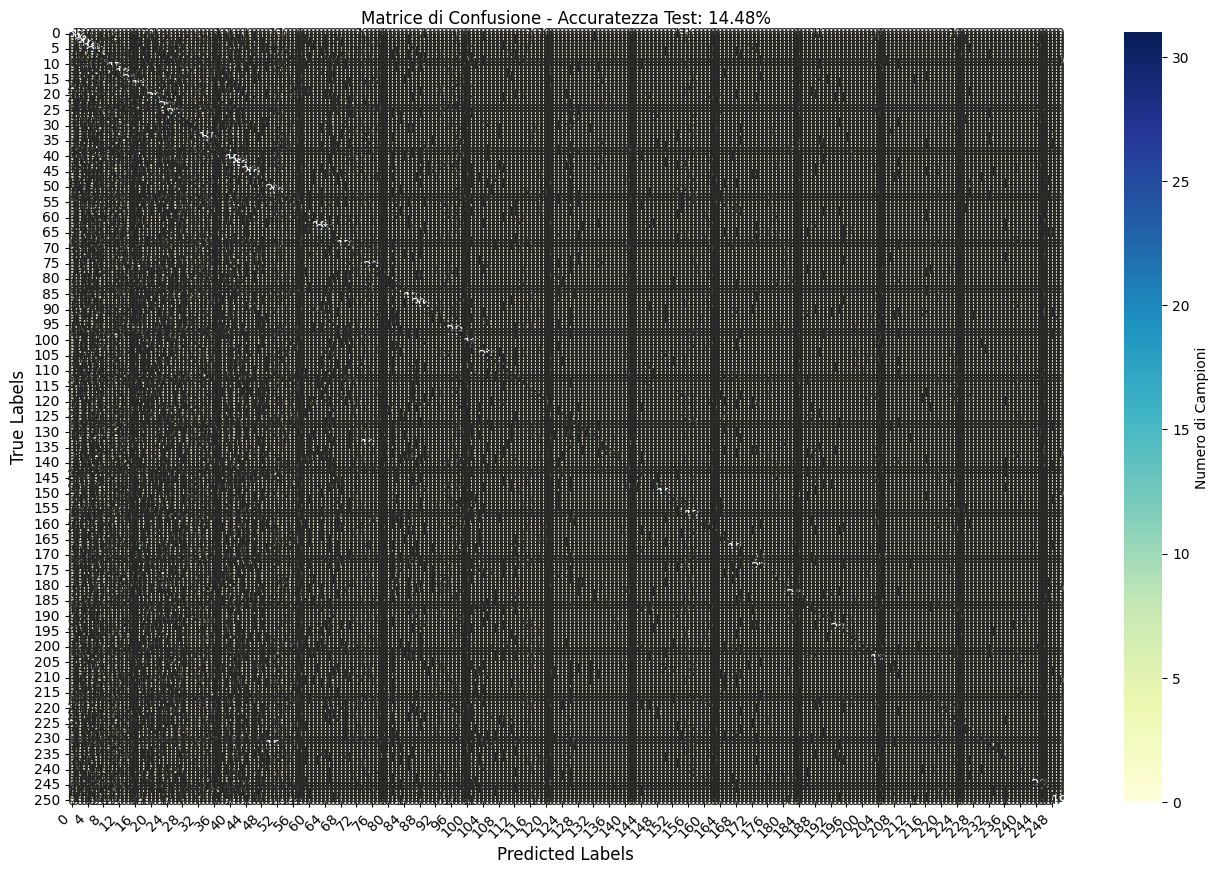

In [15]:
# Matrice di confusione per il test set
y_test_pred_classes = y_test_pred
y_test_true_classes = np.argmax(y_test_true, axis=1)
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Visualizzazione matrice di confusione
plt.figure(figsize=(16, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            cbar_kws={'label': 'Numero di Campioni'}, annot_kws={"size": 10})
plt.title(f"Matrice di Confusione - Accuratezza Test: {test_accuracy_top1 * 100:.2f}%")
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [16]:
# Accuratezza per classe per il test set
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nAccuratezza per Classe sul Test Set:")
for i, acc in enumerate(class_accuracies):
    print(f"  Classe {i}: Accuratezza = {acc * 100:.2f}%")


Accuratezza per Classe sul Test Set:
  Classe 0: Accuratezza = 56.36%
  Classe 1: Accuratezza = 45.90%
  Classe 2: Accuratezza = 35.85%
  Classe 3: Accuratezza = 41.18%
  Classe 4: Accuratezza = 43.90%
  Classe 5: Accuratezza = 32.69%
  Classe 6: Accuratezza = 43.86%
  Classe 7: Accuratezza = 9.26%
  Classe 8: Accuratezza = 28.57%
  Classe 9: Accuratezza = 28.26%
  Classe 10: Accuratezza = 16.67%
  Classe 11: Accuratezza = 31.91%
  Classe 12: Accuratezza = 17.78%
  Classe 13: Accuratezza = 24.59%
  Classe 14: Accuratezza = 8.70%
  Classe 15: Accuratezza = 36.84%
  Classe 16: Accuratezza = 24.49%
  Classe 17: Accuratezza = 26.32%
  Classe 18: Accuratezza = 16.13%
  Classe 19: Accuratezza = 20.41%
  Classe 20: Accuratezza = 9.52%
  Classe 21: Accuratezza = 41.51%
  Classe 22: Accuratezza = 28.57%
  Classe 23: Accuratezza = 17.86%
  Classe 24: Accuratezza = 37.04%
  Classe 25: Accuratezza = 20.69%
  Classe 26: Accuratezza = 40.35%
  Classe 27: Accuratezza = 14.81%
  Classe 28: Accuratezz

# Classification using NN with cross validation

In [19]:
# Parametri per la cross-validation
k = 10  # Numero di fold per la cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Per salvare i risultati
fold_test_losses = []
fold_test_accuracies_top1 = []
fold_test_accuracies_top5 = []

In [24]:
# Parametri per la cross-validation
k = 10  # Numero di fold per la cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Per salvare i risultati
fold_test_losses = []
fold_test_accuracies_top1 = []
fold_test_accuracies_top5 = []
fold_degraded_accuracies_top1 = []
fold_degraded_accuracies_top5 = []

In [27]:
# Cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(training_set)):
    print(f"\n--- Fold {fold + 1}/{k} ---")
    
    # Creazione dei dataloader per il fold corrente
    train_fold = torch.utils.data.Subset(training_set, train_idx)
    val_fold = torch.utils.data.Subset(training_set, val_idx)
    
    train_loader = DataLoader(train_fold, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_fold, batch_size=batch_size, shuffle=False)
    
    # Reinizializza il modello, l'optimizer e il criterio per ogni fold
    model = ClassifierNetwork(input_dim, num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    
    # Early stopping
    best_val_loss = float('inf')
    early_stop_counter = 0
    patience = 10
    
    # Training
    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, _, _ = validate(model, val_loader, criterion, device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            best_model_state = model.state_dict()
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print(f"  Early stopping at epoch {epoch + 1}")
            break
        
        scheduler.step()
    
    # Test sul test set
    model.load_state_dict(best_model_state)
    test_loss, test_accuracy_top1, test_accuracy_top5, _, _ = test_validate(model, test_loader, criterion, device)

    # Test sul test set degradato
    _, degraded_accuracy_top1, degraded_accuracy_top5, _, _= test_validate(model, test_degraded_loader, criterion, device)
    
    # Salva i risultati per il fold corrente
    fold_test_losses.append(test_loss)
    fold_test_accuracies_top1.append(test_accuracy_top1)
    fold_test_accuracies_top5.append(test_accuracy_top5)
    fold_degraded_accuracies_top1.append(degraded_accuracy_top1)
    fold_degraded_accuracies_top5.append(degraded_accuracy_top5)
    
    print(f"Fold {fold + 1} Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy Top-1: {test_accuracy_top1 * 100:.2f}%")
    print(f"  Test Accuracy Top-5: {test_accuracy_top5 * 100:.2f}%")
    print(f"  Degraded Accuracy Top-1: {degraded_accuracy_top1 * 100:.2f}%")
    print(f"  Degraded Accuracy Top-5: {degraded_accuracy_top5 * 100:.2f}%")


--- Fold 1/10 ---
  Early stopping at epoch 16
Fold 1 Results:
  Test Loss: 4.6173
  Test Accuracy Top-1: 20.25%
  Test Accuracy Top-5: 41.31%
  Degraded Accuracy Top-1: 14.22%
  Degraded Accuracy Top-5: 30.32%

--- Fold 2/10 ---
  Early stopping at epoch 20
Fold 2 Results:
  Test Loss: 4.6249
  Test Accuracy Top-1: 20.09%
  Test Accuracy Top-5: 40.85%
  Degraded Accuracy Top-1: 14.18%
  Degraded Accuracy Top-5: 30.46%

--- Fold 3/10 ---
  Early stopping at epoch 16
Fold 3 Results:
  Test Loss: 4.6082
  Test Accuracy Top-1: 20.72%
  Test Accuracy Top-5: 41.15%
  Degraded Accuracy Top-1: 14.59%
  Degraded Accuracy Top-5: 30.45%

--- Fold 4/10 ---
  Early stopping at epoch 17
Fold 4 Results:
  Test Loss: 4.6028
  Test Accuracy Top-1: 20.49%
  Test Accuracy Top-5: 41.07%
  Degraded Accuracy Top-1: 14.12%
  Degraded Accuracy Top-5: 30.42%

--- Fold 5/10 ---
  Early stopping at epoch 18
Fold 5 Results:
  Test Loss: 4.6446
  Test Accuracy Top-1: 20.41%
  Test Accuracy Top-5: 40.88%
  Degrad

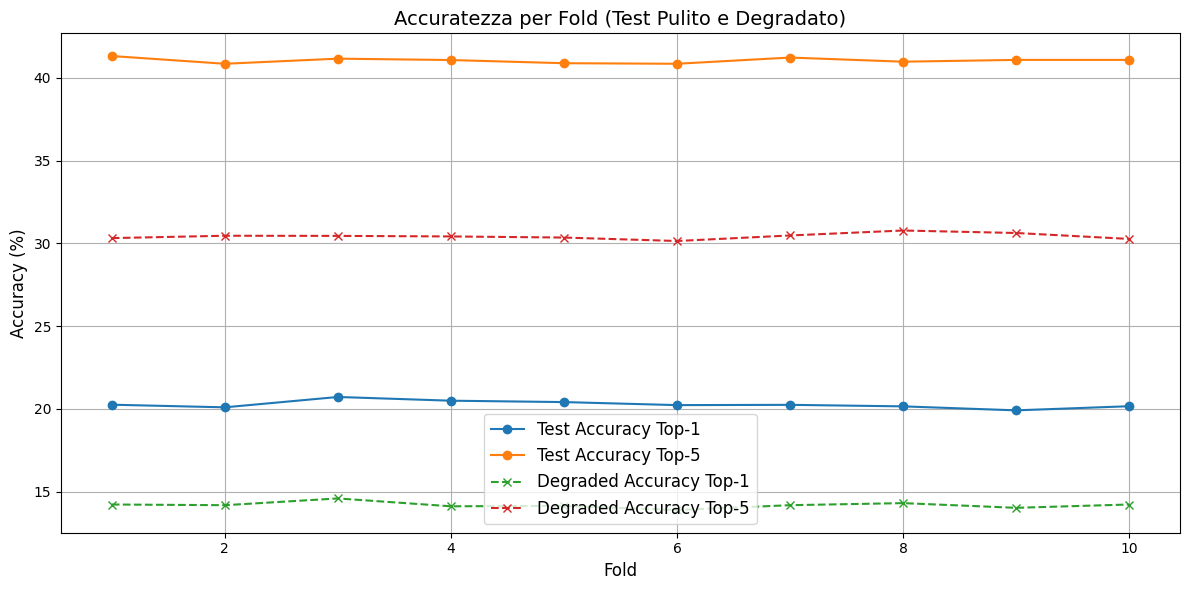


--- Risultati Finali ---
Media Test Loss: 4.6286 ± 0.0202
Media Accuracy Top-1: 20.27% ± 0.21%
Media Accuracy Top-5: 41.05% ± 0.15%
Media Degraded Accuracy Top-1: 14.19% ± 0.17%
Media Degraded Accuracy Top-5: 30.43% ± 0.17%


In [29]:
# Grafico delle accuratezze (Top-1 e Top-5) per ogni fold
plt.figure(figsize=(12, 6))
plt.plot(range(1, k + 1), [acc * 100 for acc in fold_test_accuracies_top1], marker='o', label='Test Accuracy Top-1')
plt.plot(range(1, k + 1), [acc * 100 for acc in fold_test_accuracies_top5], marker='o', label='Test Accuracy Top-5')
plt.plot(range(1, k + 1), [acc * 100 for acc in fold_degraded_accuracies_top1], marker='x', label='Degraded Accuracy Top-1', linestyle='--')
plt.plot(range(1, k + 1), [acc * 100 for acc in fold_degraded_accuracies_top5], marker='x', label='Degraded Accuracy Top-5', linestyle='--')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuratezza per Fold (Test Pulito e Degradato)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Riassunto dei risultati
print("\n--- Risultati Finali ---")
print(f"Media Test Loss: {np.mean(fold_test_losses):.4f} ± {np.std(fold_test_losses):.4f}")
print(f"Media Accuracy Top-1: {np.mean(fold_test_accuracies_top1) * 100:.2f}% ± {np.std(fold_test_accuracies_top1) * 100:.2f}%")
print(f"Media Accuracy Top-5: {np.mean(fold_test_accuracies_top5) * 100:.2f}% ± {np.std(fold_test_accuracies_top5) * 100:.2f}%")
print(f"Media Degraded Accuracy Top-1: {np.mean(fold_degraded_accuracies_top1) * 100:.2f}% ± {np.std(fold_degraded_accuracies_top1) * 100:.2f}%")
print(f"Media Degraded Accuracy Top-5: {np.mean(fold_degraded_accuracies_top5) * 100:.2f}% ± {np.std(fold_degraded_accuracies_top5) * 100:.2f}%")